<a href="https://colab.research.google.com/github/rutuja-patil24/CMPE-258-Deep_Learning/blob/main/Assignment_02/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rutujapatil241997 (rutujapatil241997-san-jose-state-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


100%|██████████| 170M/170M [00:03<00:00, 49.2MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 173MB/s]


Epoch 1, Loss: 0.8932, Accuracy: 69.38%
Epoch 2, Loss: 0.5741, Accuracy: 80.55%
Epoch 3, Loss: 0.4399, Accuracy: 85.16%
Epoch 4, Loss: 0.3452, Accuracy: 88.26%
Epoch 5, Loss: 0.2820, Accuracy: 90.47%
Epoch 6, Loss: 0.2222, Accuracy: 92.52%
Epoch 7, Loss: 0.1711, Accuracy: 94.13%
Epoch 8, Loss: 0.1463, Accuracy: 95.07%
Epoch 9, Loss: 0.1251, Accuracy: 95.72%
Epoch 10, Loss: 0.1034, Accuracy: 96.55%
Test Accuracy:  80.36
              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1000
           1       0.91      0.83      0.87      1000
           2       0.85      0.67      0.75      1000
           3       0.71      0.57      0.63      1000
           4       0.78      0.85      0.81      1000
           5       0.66      0.80      0.72      1000
           6       0.89      0.87      0.88      1000
           7       0.87      0.84      0.85      1000
           8       0.92      0.83      0.87      1000
           9       0.74      0.92   

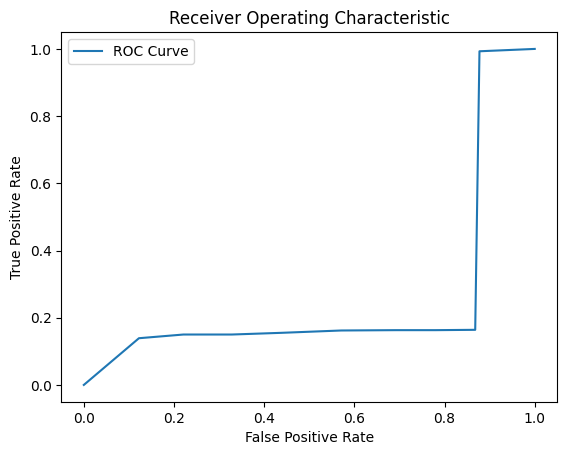

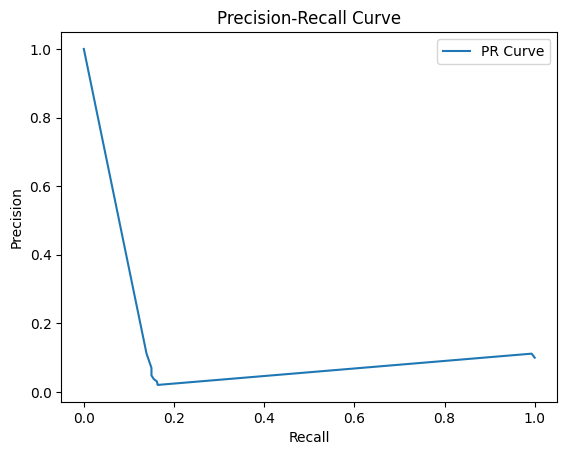

accuracy,▁▄▅▆▆▇▇███
loss,█▅▄▃▃▂▂▁▁▁
test_accuracy,▁
accuracy,96.552
loss,0.10336
test_accuracy,80.36


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import wandb
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Initialize Weights & Biases (W&B) for experiment tracking
wandb.init(project="cifar10-resnet-pytorch")

# Define transformations to normalize and convert images to tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset (train and test splits)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for batch processing
trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Load a pre-trained ResNet-18 model and modify the final fully connected layer
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjust for 10 CIFAR-10 classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train(model, trainloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            running_loss += loss.item()
            _, predicted = outputs.max(1)  # Get predicted class
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        # Log loss and accuracy to W&B
        wandb.log({"loss": running_loss / len(trainloader), "accuracy": 100. * correct / total})
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {100. * correct / total:.2f}%')

# Testing function
def test(model, testloader):
    model.eval()
    correct, total = 0, 0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  # Forward pass
            _, predicted = outputs.max(1)  # Get predicted class
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Print test accuracy and classification report
    print("Test Accuracy: ", 100. * correct / total)
    print(classification_report(all_labels, all_preds))

    # Log test accuracy to W&B
    wandb.log({"test_accuracy": 100. * correct / total})
    return all_labels, all_preds

# Train and evaluate the model
train(model, trainloader, criterion, optimizer, epochs=10)
labels, preds = test(model, testloader)

# Compute ROC and PR curves
fpr, tpr, _ = roc_curve(labels, preds, pos_label=1)
precision, recall, _ = precision_recall_curve(labels, preds, pos_label=1)

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.show()

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall, precision, label='PR Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Finish W&B logging
wandb.finish()
